<a href="https://colab.research.google.com/github/JiseokSeo/Image-preprocessing-for-reliable-healthcare-AI/blob/main/segmentations_and_gradCAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 이미지 + 바운딩박스=> 크롭된 모델 ==(512, 512)로 reshape==>  

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# kaggle API로 데이터를 다운로드합니다.
# kaggle token을 업로드해야합니다 -> 발급받아야함

from google.colab import files
kaggle_token = files.upload()

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
!kaggle datasets download -d nikhilpandey360/chest-xray-masks-and-labels

100% 9.55G/9.58G [01:24<00:00, 192MB/s]
100% 9.58G/9.58G [01:24<00:00, 122MB/s]


In [ ]:
!unzip -q /content/chest-xray-masks-and-labels.zip

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
from glob import glob
from tqdm import tqdm
import re
import cv2
from collections import defaultdict

import torch
import torch.nn as nn

In [ ]:
## 특정 디렉토리에서 다른 디렉토리로 파일 옮기기

def move_files(orgin_path, target_path):
  for filename in os.listdir(orgin_path):
    if os.path.isfile(os.path.join(orgin_path, filename)):
        shutil.move(os.path.join(orgin_path, filename), target_path)

In [ ]:
def mask_tail(mask_paths):
  mask_names = []
  for string in mask_paths:
    if not string.split('.png')[0].endswith('mask'):
      string = string.split('.png')[0] + '_mask.png'
      mask_names.append(string)
    else:
      mask_names.append(string)

  return mask_names

In [ ]:
DIR = "/content/data/"

lung_image_paths = glob(os.path.join(DIR,"Lung Segmentation/CXR_png/*.png"))
mask_image_paths = glob(os.path.join(DIR,"Lung Segmentation/masks/*.png"))

related_paths = defaultdict(list)

for img_path in lung_image_paths:
    img_match = re.search("CXR_png/(.*)\.png$", img_path)
    if img_match:
        img_name = img_match.group(1)
    for mask_path in mask_image_paths:
        mask_match = re.search(img_name, mask_path)
        if mask_match:
            related_paths["image_path"].append(img_path)
            related_paths["mask_path"].append(mask_path)

df = pd.DataFrame.from_dict(related_paths)

In [ ]:
df

image_path  \
0    /content/data/Lung Segmentation/CXR_png/MCUCXR...   
1    /content/data/Lung Segmentation/CXR_png/CHNCXR...   
2    /content/data/Lung Segmentation/CXR_png/CHNCXR...   
3    /content/data/Lung Segmentation/CXR_png/MCUCXR...   
4    /content/data/Lung Segmentation/CXR_png/CHNCXR...   
..                                                 ...   
699  /content/data/Lung Segmentation/CXR_png/CHNCXR...   
700  /content/data/Lung Segmentation/CXR_png/CHNCXR...   
701  /content/data/Lung Segmentation/CXR_png/MCUCXR...   
702  /content/data/Lung Segmentation/CXR_png/MCUCXR...   
703  /content/data/Lung Segmentation/CXR_png/CHNCXR...   

                                             mask_path  
0    /content/data/Lung Segmentation/masks/MCUCXR_0...  
1    /content/data/Lung Segmentation/masks/CHNCXR_0...  
2    /content/data/Lung Segmentation/masks/CHNCXR_0...  
3    /content/data/Lung Segmentation/masks/MCUCXR_0...  
4    /content/data/Lung Segmentation/masks/CHNCXR_0...  
..                                                 ...  
699  /content/data/Lung Segmentation/masks/CHNCXR_0...  
700  /content/data/Lung Segmentation/masks/CHNCXR_0...  
701  /content/data/Lung Segmentation/masks/MCUCXR_0...  
702  /content/data/Lung Segmentation/masks/MCUCXR_0...  
703  /content/data/Lung Segmentation/masks/CHNCXR_0...  

[704 rows x 2 columns]

In [ ]:
from sklearn.model_selection import train_test_split

train, valid = train_test_split(df,
                                test_size=0.1,
                                random_state=42)

In [ ]:
train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)

### 모델링

In [ ]:
!pip install -q segmentation_models_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 9.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 25.2 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp
import segmentation_models_pytorch as smp

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def build_model():
    model = smp.Unet(
        encoder_name='efficientnet-b1',      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
        in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=1,        # model output channels (number of classes in your dataset)
        activation=None,
    )
    model.to(device)
    return model

### 데이터세트 

In [ ]:
class Dataset(Dataset):
  def __init__(self, df, transform):
    self.df = df
    self.transform_image = transform['image']
    self.transform_mask = transform['mask']
  
  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):
    image_path = self.df.loc[index, 'image_path']
    image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    image = self.transform_image(image=image)['image']
    image = image.float()

    mask_path = self.df.loc[index, 'mask_path']
    mask = cv2.cvtColor(cv2.imread(mask_path), cv2.COLOR_BGR2GRAY)
    mask = self.transform_mask(image=mask)['image']
    mask = mask.float() / 255.0

    return {'image':image,
            'mask':mask}

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [ ]:
## Dataset check
transform = {'image':A.Compose([A.Resize(256, 256),
                                       ToTensorV2()]),
             'mask':A.Compose([A.Resize(256, 256),
                               ToTensorV2()])}

dataset = Dataset(df, transform)
dataloader = DataLoader(dataset, shuffle=True, num_workers=2, batch_size=16)

In [ ]:
dataset[0]['image'].shape

torch.Size([3, 256, 256])

In [ ]:
dataset[0]['mask'].max()

tensor(1.)

In [ ]:
test_model = build_model()
test_model.to(device)
test_output = test_model(dataset[0]['image'].unsqueeze(0).to(device))
test_output.shape

torch.Size([1, 1, 256, 256])

### 학습 

In [ ]:
train_dataset = Dataset(train, transform)
train_dataloader = DataLoader(train_dataset, shuffle=True, num_workers=2, batch_size=16)

valid_dataset = Dataset(valid, transform)
valid_dataloader = DataLoader(valid_dataset, shuffle=False, num_workers=2, batch_size=16)

In [ ]:
num_epochs = 50
patience = 5
early_stopping_counter = 0
best_val_loss = float('inf')
train_losses = []
val_losses = []
train_accs = []
val_accs = []

In [ ]:
model = build_model().to(device)
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
def visualize_sample(image, mask, pred_mask, threshold=0.5):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

    ax1.imshow(image.permute(2, 1, 0).cpu().numpy())
    ax1.set_title("Input Image")
    ax1.axis("off")

    ax2.imshow(mask.squeeze().cpu().numpy(), cmap="gray")
    ax2.set_title("Ground Truth Mask")
    ax2.axis("off")

    binary_pred_mask = (pred_mask > threshold).float()
    ax3.imshow(binary_pred_mask.squeeze().cpu().numpy(), cmap="gray")
    ax3.set_title("Predicted Binary Mask")
    ax3.axis("off")

    plt.show()

In [ ]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    train_loss = 0.0
    total = 0

    for batch in tqdm(dataloader, desc="Training", leave=False):
        images = batch['image'].to(device)
        masks = batch['mask'].to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        total += masks.size(0)

    return train_loss / len(dataloader)


def validate(model, dataloader, criterion, device):
    model.eval()
    val_loss = 0.0
    total = 0

    with torch.no_grad():
        for i, batch in enumerate(tqdm(dataloader, desc="Validation", leave=False)):
            images = batch['image'].to(device)
            masks = batch['mask'].to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)

            val_loss += loss.item()
            total += masks.size(0)

            if i == 0:  # Show the first sample from the first batch after every epoch
                input_image = images[0]
                true_mask = masks[0]
                pred_mask = torch.sigmoid(outputs[0])

                visualize_sample(input_image, true_mask, pred_mask)

    return val_loss / len(dataloader)

Validation:   0%|          | 0/5 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


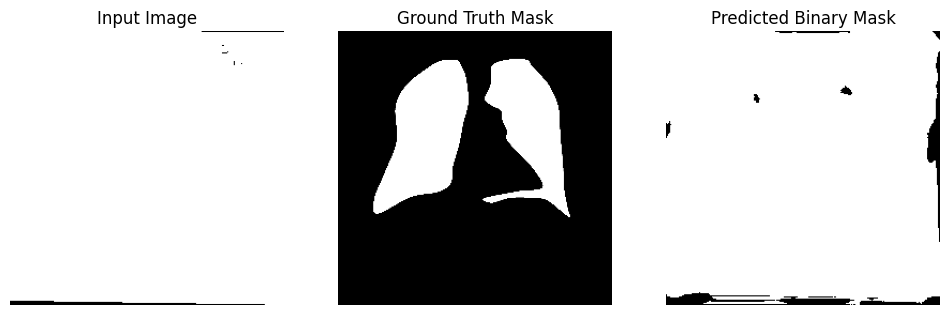

Epoch 1/50, Train Loss: 0.2064, Val Loss: 3.8500
Validation loss improved from inf to 3.8500. Saving model...


Validation:   0%|          | 0/5 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


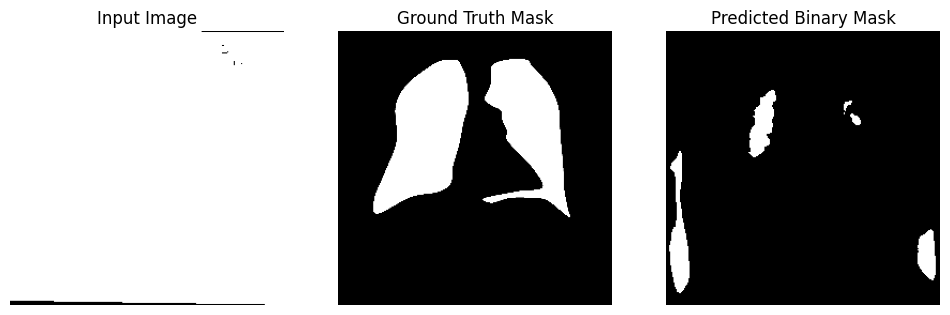

Epoch 2/50, Train Loss: 0.0717, Val Loss: 0.4189
Validation loss improved from 3.8500 to 0.4189. Saving model...


Validation:   0%|          | 0/5 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


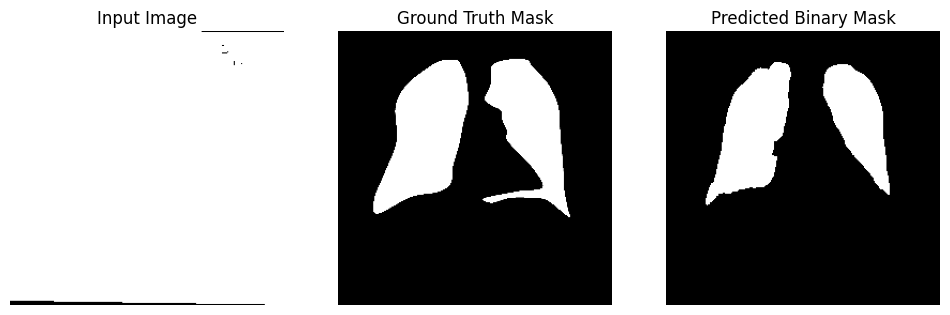

Epoch 3/50, Train Loss: 0.0579, Val Loss: 0.0814
Validation loss improved from 0.4189 to 0.0814. Saving model...


Validation:   0%|          | 0/5 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


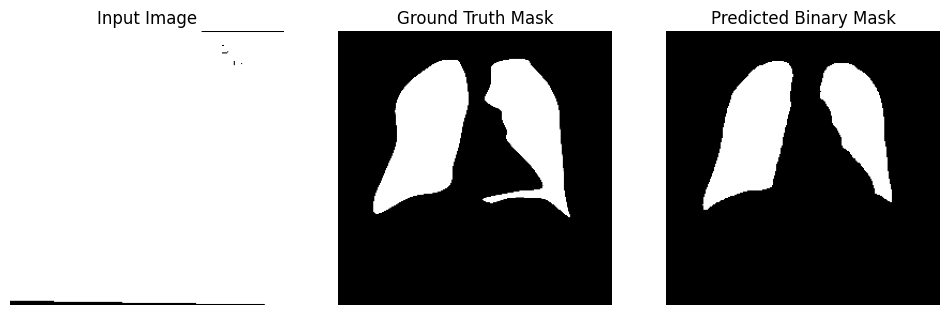

Epoch 4/50, Train Loss: 0.0509, Val Loss: 0.0555
Validation loss improved from 0.0814 to 0.0555. Saving model...


Validation:   0%|          | 0/5 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


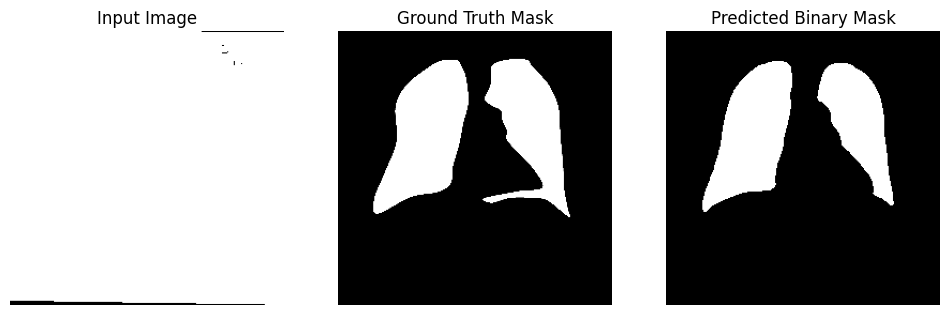

Epoch 5/50, Train Loss: 0.0465, Val Loss: 0.0480
Validation loss improved from 0.0555 to 0.0480. Saving model...


Training:  15%|█▌        | 6/40 [00:20<01:30,  2.66s/it]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7c2352f4c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7c2352f4c0>
Traceback (most recent call last):
      File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shut

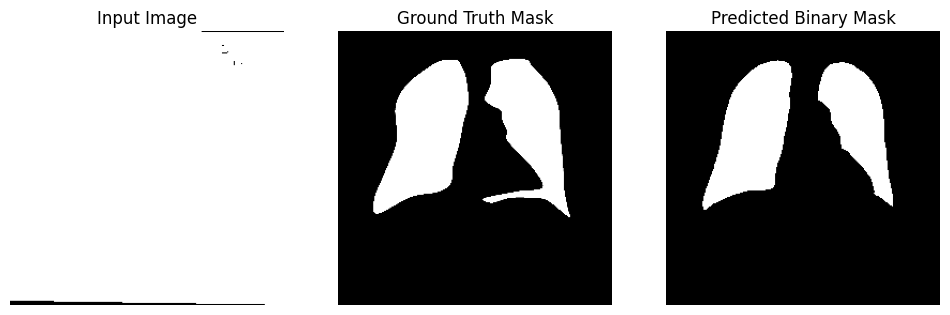

Epoch 6/50, Train Loss: 0.0422, Val Loss: 0.0484
Early stopping counter: 1/5


Validation:   0%|          | 0/5 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


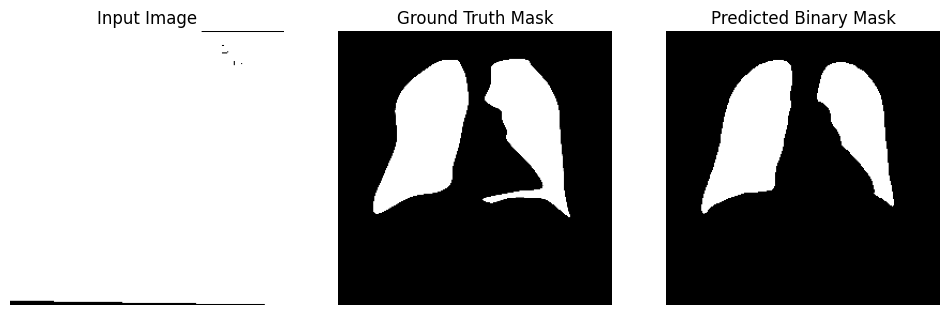

Epoch 7/50, Train Loss: 0.0413, Val Loss: 0.0459
Validation loss improved from 0.0480 to 0.0459. Saving model...


Validation:   0%|          | 0/5 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


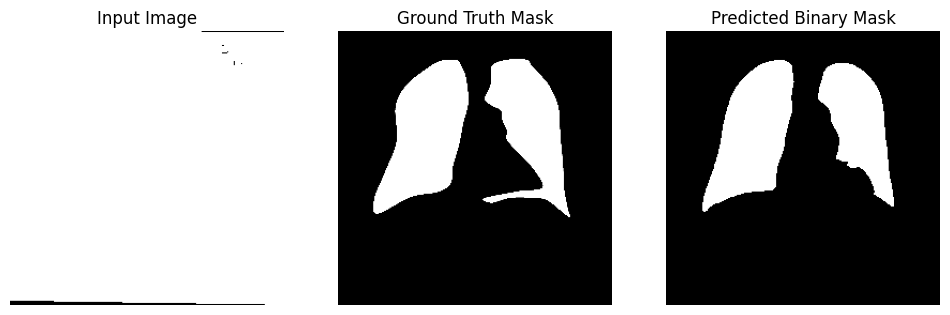

Epoch 8/50, Train Loss: 0.0390, Val Loss: 0.0426
Validation loss improved from 0.0459 to 0.0426. Saving model...


Validation:   0%|          | 0/5 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


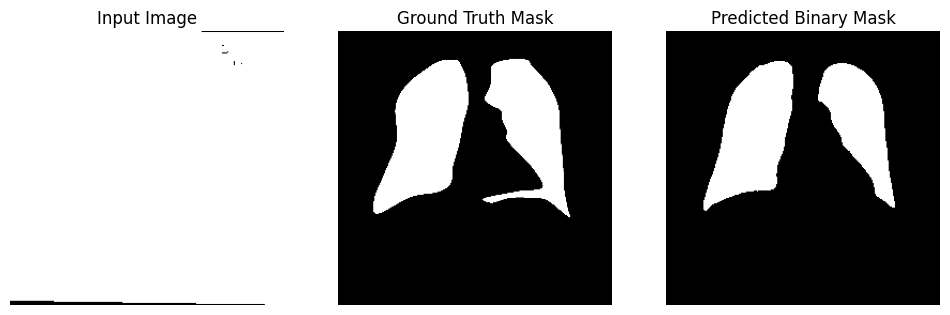

Epoch 9/50, Train Loss: 0.0352, Val Loss: 0.0460
Early stopping counter: 1/5


Validation:   0%|          | 0/5 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


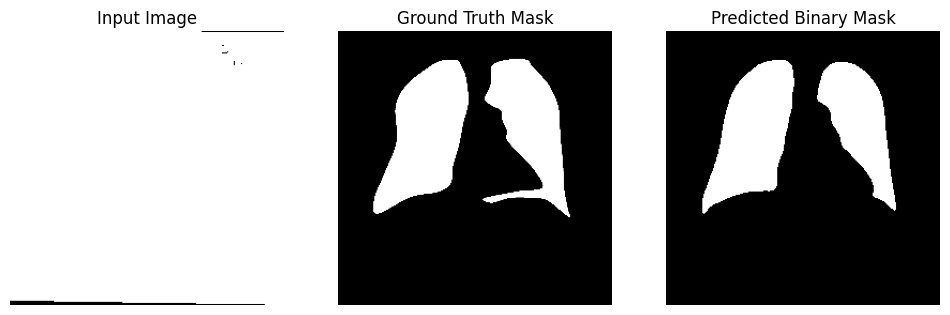

Epoch 10/50, Train Loss: 0.0332, Val Loss: 0.0465
Early stopping counter: 2/5


Validation:   0%|          | 0/5 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


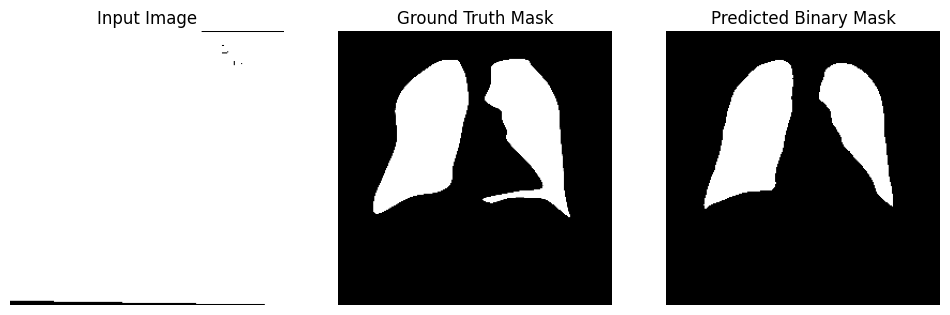

Epoch 11/50, Train Loss: 0.0327, Val Loss: 0.0497
Early stopping counter: 3/5


Validation:   0%|          | 0/5 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


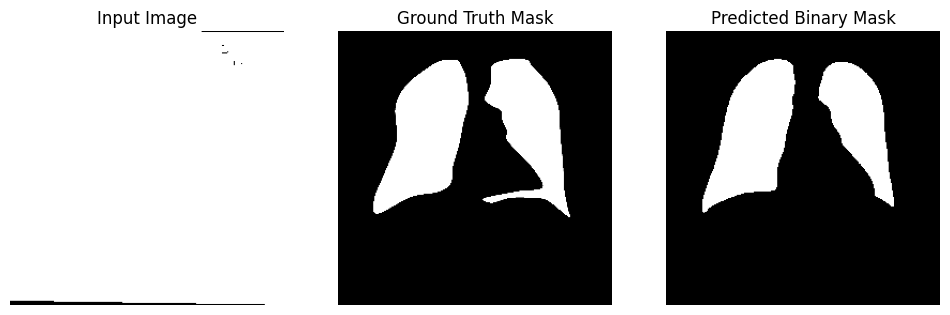

Epoch 12/50, Train Loss: 0.0322, Val Loss: 0.0446
Early stopping counter: 4/5


Validation:   0%|          | 0/5 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


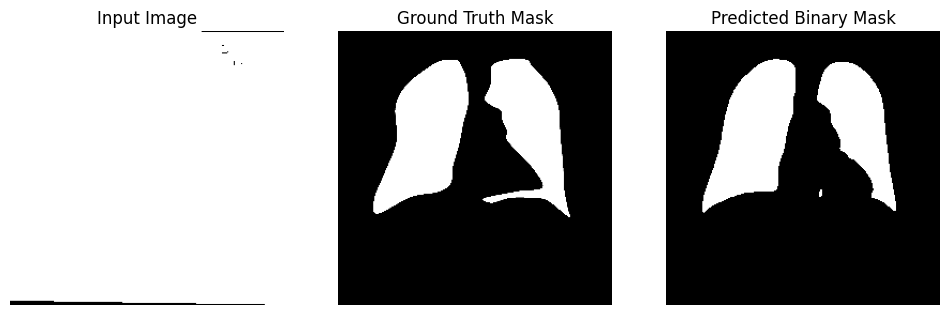

Epoch 13/50, Train Loss: 0.0311, Val Loss: 0.0481
Early stopping counter: 5/5
Early stopping triggered. Stopping training.


In [ ]:
for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_dataloader, criterion, optimizer, device)
    val_loss = validate(model, valid_dataloader, criterion, device)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if val_loss < best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {val_loss:.4f}. Saving model...")
        torch.save(model.state_dict(), '/content/drive/MyDrive/segmentation_model/best_model.pth')
        best_val_loss = val_loss
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        print(f"Early stopping counter: {early_stopping_counter}/{patience}")

        if early_stopping_counter >= patience:
            print("Early stopping triggered. Stopping training.")
            break

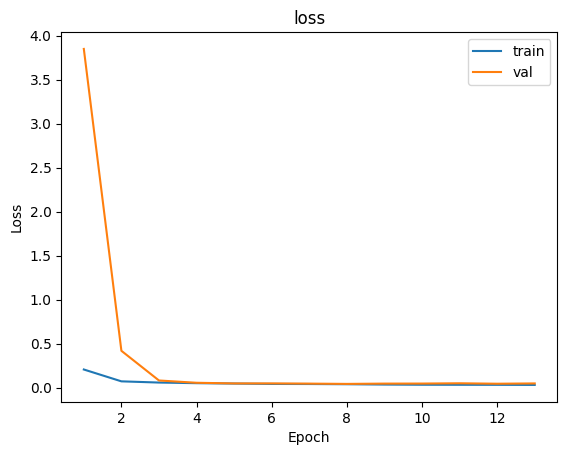

In [ ]:
plt.plot(range(1, len(train_losses)+1), train_losses, label='train')
plt.plot(range(1, len(val_losses)+1), val_losses, label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('loss')
plt.legend()
plt.show()

### inference

In [ ]:
# data 디렉토리 생성
!mkdir /content/data

# 캐글 데이터 다운로드
!kaggle competitions download -c rsna-pneumonia-detection-challenge

# 다운로드 받은 케글 데이터를 data 디렉토리로 이동
!mv rsna-pneumonia-detection-challenge.zip /content/data

# 캐글 데이터를 data 디렉토리에 압축풀기
!unzip -q /content/data/rsna-pneumonia-detection-challenge.zip -d /content/data

mkdir: cannot create directory ‘/content/data’: File exists
100% 3.65G/3.66G [00:38<00:00, 89.3MB/s]
100% 3.66G/3.66G [00:38<00:00, 102MB/s] 


In [ ]:
!mkdir /content/labels
!mkdir /content/labels/train
!mkdir /content/labels/test

!unzip -q /content/drive/MyDrive/train_label.zip -d /content/labels/train
!unzip -q /content/drive/MyDrive/test_label.zip -d /content/labels/test

In [ ]:
!mkdir /content/images
!mkdir /content/images/train
!mkdir /content/images/test

!unzip -q /content/drive/MyDrive/P_images.zip -d /content/images/train
!unzip -q /content/drive/MyDrive/P_images_test.zip -d /content/images/test

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import copy
import glob
from tqdm import tqdm
import zipfile
from sklearn.model_selection import train_test_split
import yaml
import torch
import shutil
import random
import math
from tqdm import tqdm
import csv
import albumentations as A
from albumentations import Compose, CLAHE
from albumentations.core.transforms_interface import ImageOnlyTransform
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.preprocessing import LabelEncoder

In [ ]:
train = pd.read_csv('/content/data/stage_2_detailed_class_info.csv')
train['class'].unique()

array(['No Lung Opacity / Not Normal', 'Normal', 'Lung Opacity'],
      dtype=object)

In [ ]:
train['class'] = train['class'].map({'Normal':0,
                                     'No Lung Opacity / Not Normal':1,
                                     'Lung Opacity':2})

In [ ]:
image_root = '/content/images/train'
label_root = '/content/labels/train/train_label'
train['image_path'] = train['patientId'].apply(lambda x: os.path.join(image_root, x + '.png'))
train['bbox_path'] = train['patientId'].apply(lambda x: os.path.join(label_root, x + '.txt'))
train

patientId  class  \
0      0004cfab-14fd-4e49-80ba-63a80b6bddd6      1   
1      00313ee0-9eaa-42f4-b0ab-c148ed3241cd      1   
2      00322d4d-1c29-4943-afc9-b6754be640eb      1   
3      003d8fa0-6bf1-40ed-b54c-ac657f8495c5      0   
4      00436515-870c-4b36-a041-de91049b9ab4      2   
...                                     ...    ...   
30222  c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8      2   
30223  c1edf42b-5958-47ff-a1e7-4f23d99583ba      0   
30224  c1f6b555-2eb1-4231-98f6-50a963976431      0   
30225  c1f7889a-9ea9-4acb-b64c-b737c929599a      2   
30226  c1f7889a-9ea9-4acb-b64c-b737c929599a      2   

                                              image_path  \
0      /content/images/train/0004cfab-14fd-4e49-80ba-...   
1      /content/images/train/00313ee0-9eaa-42f4-b0ab-...   
2      /content/images/train/00322d4d-1c29-4943-afc9-...   
3      /content/images/train/003d8fa0-6bf1-40ed-b54c-...   
4      /content/images/train/00436515-870c-4b36-a041-...   
...                                                  ...   
30222  /content/images/train/c1ec14ff-f6d7-4b38-b0cb-...   
30223  /content/images/train/c1edf42b-5958-47ff-a1e7-...   
30224  /content/images/train/c1f6b555-2eb1-4231-98f6-...   
30225  /content/images/train/c1f7889a-9ea9-4acb-b64c-...   
30226  /content/images/train/c1f7889a-9ea9-4acb-b64c-...   

                                               bbox_path  
0      /content/labels/train/train_label/0004cfab-14f...  
1      /content/labels/train/train_label/00313ee0-9ea...  
2      /content/labels/train/train_label/00322d4d-1c2...  
3      /content/labels/train/train_label/003d8fa0-6bf...  
4      /content/labels/train/train_label/00436515-870...  
...                                                  ...  
30222  /content/labels/train/train_label/c1ec14ff-f6d...  
30223  /content/labels/train/train_label/c1edf42b-595...  
30224  /content/labels/train/train_label/c1f6b555-2eb...  
30225  /content/labels/train/train_label/c1f7889a-9ea...  
30226  /content/labels/train/train_label/c1f7889a-9ea...  

[30227 rows x 4 columns]

In [ ]:
class Dataset(Dataset):
  def __init__(self, df, is_crop=False, is_transform=False, transformer=None):
    self.df = df
    self.is_crop = is_crop
    self.is_transform = is_transform
    self.transformer = transformer

  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):
    image_path = self.df['image_path'][index]
    image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    target = self.df['class'][index]

    if self.is_crop:
      bbox_path = self.df['bbox_path'][index]

      if os.path.isfile(bbox_path):
        with open(bbox_path, 'r') as f:
          cls, x_c, y_c, w, h = list(map(float, f.read().split()))
          x1 = int(round(((x_c - w/2) * 1024), 0))
          y1 = int(round(((y_c - h/2) * 1024), 0))
          x2 = int(round(((x_c + w/2) * 1024), 0))
          y2 = int(round(((y_c + h/2) * 1024), 0))
      else:
        x1, y1, x2, y2 = 0, 0, 1023, 1023

      ROI = image[y1:y2, x1:x2]

    else:
      ROI = image

    if self.is_transform and self.transformer != None:
      ROI = self.transformer(image=ROI)['image']
    else:
      transformer_test = A.Compose([ToTensorV2()])
      ROI = transformer_test(image=ROI)['image']

    if len(ROI.shape) == 2:
      ROI = np.concatenate([ROI, ROI, ROI], axis=0)

    ROI = ROI.float()
    
    return {'image':ROI,
            'target':target}

In [ ]:
seg_model = build_model()

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b1-f1951068.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b1-f1951068.pth
100%|██████████| 30.1M/30.1M [00:00<00:00, 150MB/s]


In [ ]:
seg_model.load_state_dict(torch.load('/content/drive/MyDrive/segmentation_model/best_model.pth'))

<All keys matched successfully>

In [ ]:
seg_model.to(device)

Unet(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSamePadding

In [ ]:
transform = A.Compose([
    A.Resize(224, 224),
    ToTensorV2()
])

In [ ]:
sample_df = train.sample(16, random_state=42).reset_index(drop=True)
sample_dataset = Dataset(sample_df, is_crop=False, is_transform=True, transformer=transform)
sample_dataloader = DataLoader(sample_dataset, batch_size=4, shuffle=False, num_workers=2)

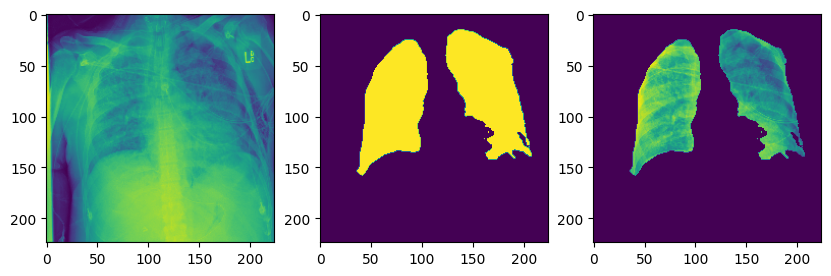

In [ ]:
sample_image = sample_dataset[12]['image']
sample_mask = seg_model(sample_image.unsqueeze(0).to(device))
sample_mask = torch.sigmoid(sample_mask)
sample_mask = (sample_mask > 0.49).float()
sample_ROI = sample_image[0].cpu().numpy() * sample_mask.cpu().numpy()

f, ax = plt.subplots(1, 3, figsize=(10, 8))
ax[0].imshow(sample_image[0])
ax[1].imshow(sample_mask.cpu()[0][0])
ax[2].imshow(sample_ROI[0][0])

In [ ]:
import os
from PIL import Image

def save_roi_images(dataloader, output_path):
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    for i, batch in enumerate(dataloader):
        images = batch['image'].to(device)
        masks = seg_model(images)
        masks = torch.sigmoid(masks)
        binary_masks = (masks > 0.49).float()

        for j, (image, mask) in enumerate(zip(images, binary_masks)):
            roi = image[0].cpu().numpy() * mask[0].cpu().numpy()
            roi_image = Image.fromarray((roi * 255).astype(np.uint8))
            roi_image.save(os.path.join(output_path, f'roi_{i * len(images) + j}.png'))

In [ ]:
# Usage example:
output_path = '/content/ROIs_non_crop'
save_roi_images(sample_dataloader, output_path)

In [ ]:
sample_df = train.sample(16, random_state=42).reset_index(drop=True)
sample_dataset = Dataset(sample_df, is_crop=True, is_transform=True, transformer=transform)
sample_dataloader = DataLoader(sample_dataset, batch_size=4, shuffle=False, num_workers=2)

In [ ]:
output_path = '/content/ROIs_crop'
save_roi_images(sample_dataloader, output_path)

In [ ]:
transform = A.Compose([
    A.Resize(224, 224),
    A.CLAHE(clip_limit=1.5, p=1),
    ToTensorV2()
])

In [ ]:
sample_df = train.sample(16, random_state=42).reset_index(drop=True)
pre_sample_dataset = Dataset(sample_df, is_crop=True, is_transform=True, transformer=transform)
pre_sample_dataloader = DataLoader(sample_dataset, batch_size=4, shuffle=False, num_workers=2)

In [ ]:
output_path = '/content/ROIs_crop_pre'
save_roi_images(pre_sample_dataloader, output_path)

## gradcam

In [ ]:
!pip install grad-cam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 47.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.6-py3-none-any.whl size=38262 sha256=8b3e01e3cf501e894225796a69ea994c8f1a97203d4369a5d31e3b43fda7f12e
  Stored in directory: /root/.cache/pip/wheels/9b/ae/bd/221d138b169c4867b2ae5c893474d0b23bae6e4750bc95bc55
Successfully built grad-cam


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import copy
import glob
from tqdm import tqdm
import zipfile
from sklearn.model_selection import train_test_split
import yaml
import torch
import shutil
import random
import math
from tqdm import tqdm
import csv
import albumentations as A
from albumentations import Compose, CLAHE
from albumentations.core.transforms_interface import ImageOnlyTransform
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
import torchvision
from torchvision.models import densenet121
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [ ]:
class DenseNetClassifier(nn.Module):
    def __init__(self, num_classes=3):
        super(DenseNetClassifier, self).__init__()
        self.model = densenet121(pretrained=True)
        
        # 기존 DenseNet121의 출력 레이어를 수정하여 3개의 클래스로 분류할 수 있도록 함
        num_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(num_features, num_classes)

    def forward(self, x):
        x = self.model(x)
        return x

In [ ]:
import math

def visualize_cam_on_images(model, disease_dataloader, k):
    for batch_idx, data in enumerate(disease_dataloader):
        if batch_idx >= k:
            break
        input_batch = data

        nrows = 4
        ncols = 4
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 15))
        axes = axes.flatten()

        for index in range(input_batch.size(0)):
            print(f"Batch {batch_idx + 1}, Image {index + 1}")
            target_layer = [model.model.features[-1]]
            input_tensor = input_batch[index].unsqueeze(0)
            targets = None

            cam = GradCAM(model=model, target_layers=target_layer, use_cuda=True)
            grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

            def tensor_to_np(tensor):
                tensor = tensor.detach().cpu().numpy().transpose(1, 2, 0)
                tensor_normalized = (tensor - np.min(tensor)) / (np.max(tensor) - np.min(tensor))
                return tensor_normalized

            rgb_img = tensor_to_np(input_batch[index])

            grayscale_cam = grayscale_cam[0, :]
            visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

            axes[index].imshow(visualization)
            axes[index].set_title(f"Batch {batch_idx + 1}, Image {index + 1}")
            axes[index].axis('off')

        plt.tight_layout()
        plt.show()

In [ ]:
def visualize_cam_on_single_image(model, disease_dataloader, B, N):
    for batch_idx, data in enumerate(disease_dataloader):
        if batch_idx == B:
            input_batch = data
            break

    target_layer = [model.model.features[-1]]
    input_tensor = input_batch[N].unsqueeze(0)
    targets = None

    cam = GradCAM(model=model, target_layers=target_layer, use_cuda=True)
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

    def tensor_to_np(tensor):
        tensor = tensor.detach().cpu().numpy().transpose(1, 2, 0)
        tensor_normalized = (tensor - np.min(tensor)) / (np.max(tensor) - np.min(tensor))
        return tensor_normalized

    rgb_img = tensor_to_np(input_batch[N])

    grayscale_cam = grayscale_cam[0, :]
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    plt.imshow(visualization)
    plt.title(f"Batch {B + 1}, Image {N + 1}")
    plt.axis('off')
    plt.show()

In [ ]:
model = DenseNetClassifier(3)
model.load_state_dict(torch.load('/content/drive/MyDrive/baseline/best_10_epochs.pth'))

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [ ]:
ROI_paths = sorted(glob.glob('/content/ROIs_non_crop/*.png'))
df_ROs_non_crop = pd.DataFrame(columns=['image_path'], data=ROI_paths)

In [ ]:
class ROIDataset(Dataset):
  def __init__(self, df, transform):
    self.df = df
    self.transform = transform

  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):
    image_path = self.df.loc[index, 'image_path']
    image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    image = self.transform(image=image)['image']
    image = image.float()

    return image

In [ ]:
transform = A.Compose([
    A.Resize(224, 224),
    ToTensorV2()
])

In [ ]:
ROs_non_crop_dataset = ROIDataset(df_ROs_non_crop, transform=transform)
ROs_non_crop_dataloader = DataLoader(ROs_non_crop_dataset, batch_size=16, shuffle=False, num_workers=2)

Batch 1, Image 1
Batch 1, Image 2
Batch 1, Image 3
Batch 1, Image 4
Batch 1, Image 5
Batch 1, Image 6
Batch 1, Image 7
Batch 1, Image 8
Batch 1, Image 9
Batch 1, Image 10
Batch 1, Image 11
Batch 1, Image 12
Batch 1, Image 13
Batch 1, Image 14
Batch 1, Image 15
Batch 1, Image 16


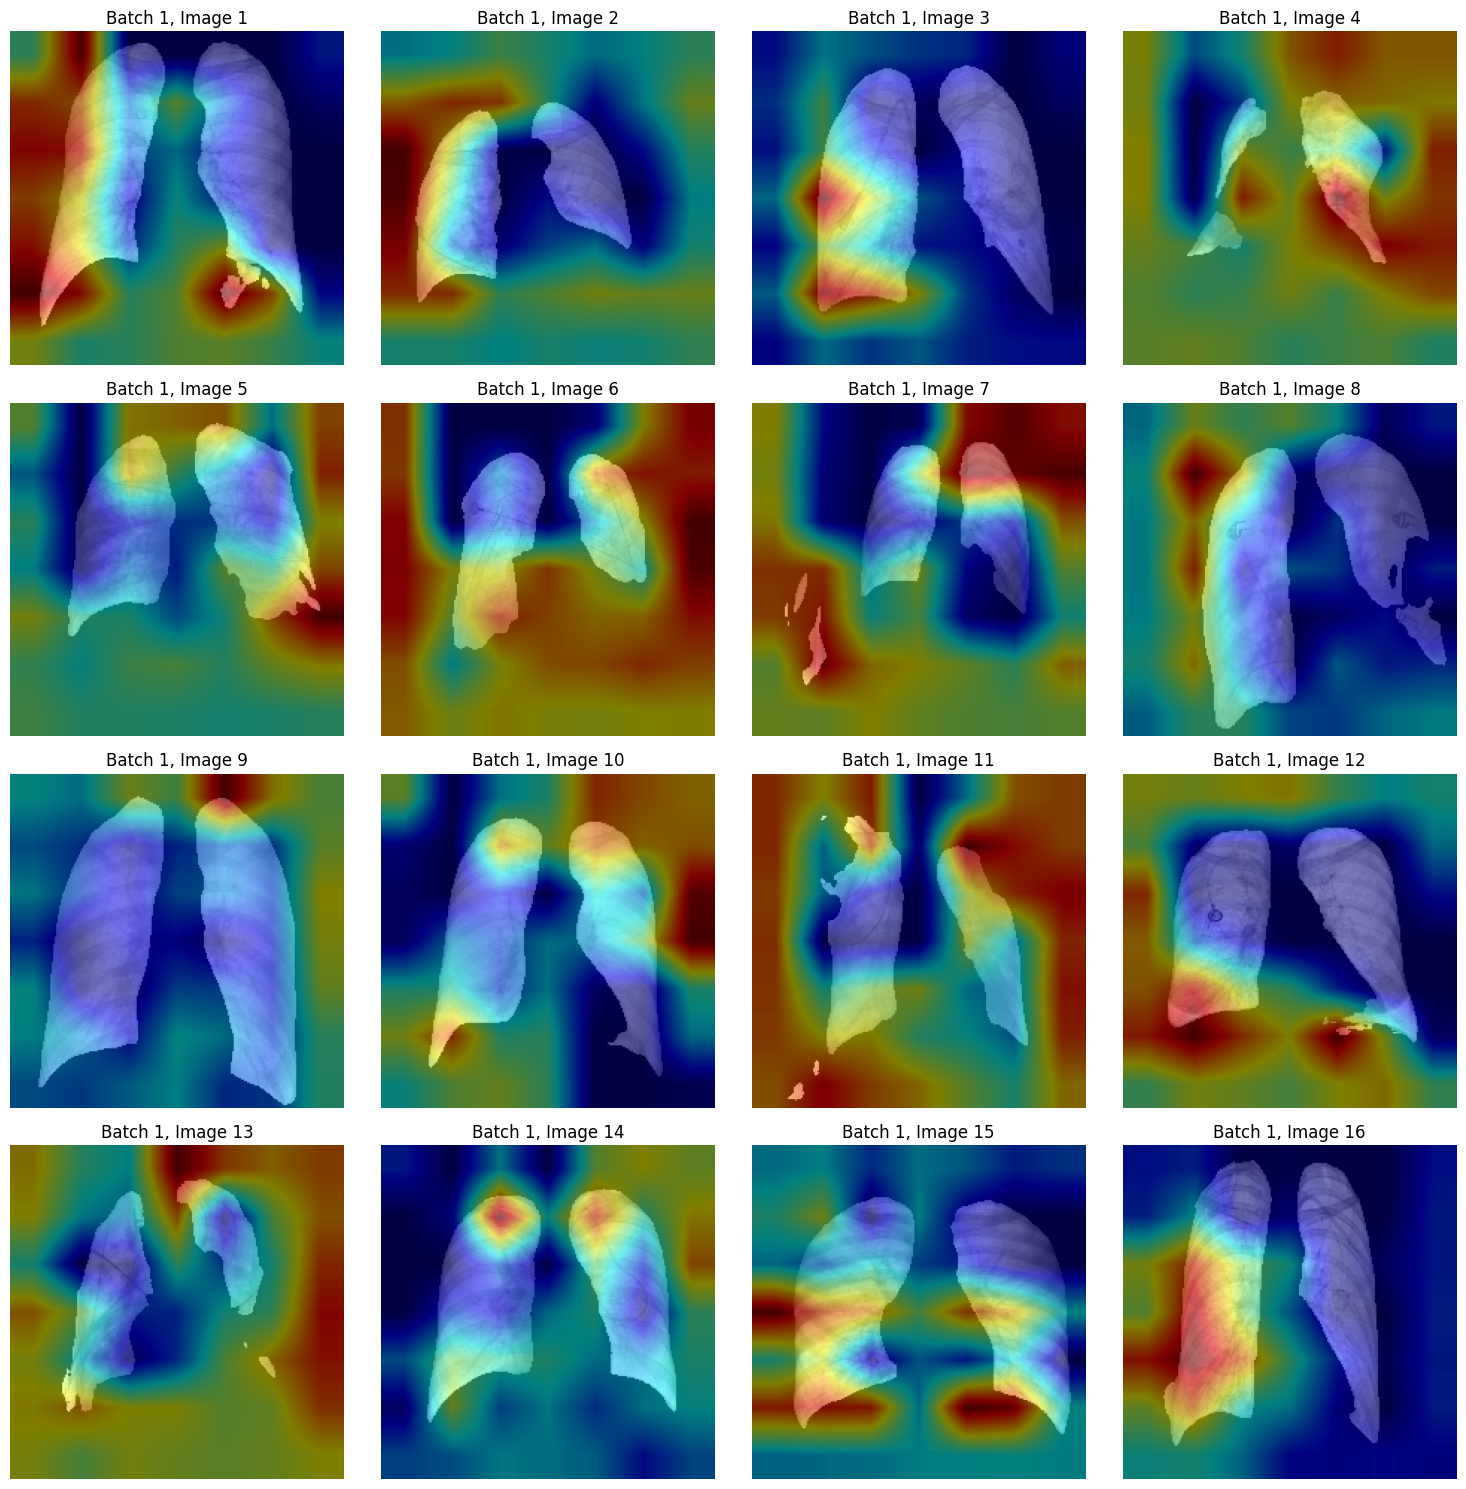

In [ ]:
visualize_cam_on_images(model, ROs_non_crop_dataloader, 16)

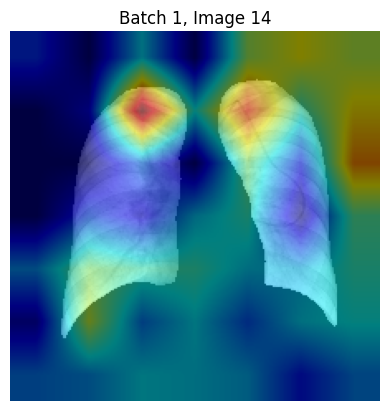

In [ ]:
visualize_cam_on_single_image(model, ROs_non_crop_dataloader, 0, 13)

In [ ]:
model2 = DenseNetClassifier(3)
model2.load_state_dict(torch.load('/content/drive/MyDrive/crop_model/best_9_epochs.pth'))

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [ ]:
df_ROs_crop_paths = sorted(glob.glob('/content/ROIs_crop/*.png'))
df_ROs_crop = pd.DataFrame(columns=['image_path'], data=df_ROs_crop_paths)
ROs_crop_dataset = ROIDataset(df_ROs_crop, transform=transform)
ROs_crop_dataloader = DataLoader(ROs_crop_dataset, batch_size=16, shuffle=False, num_workers=2)

Batch 1, Image 1
Batch 1, Image 2
Batch 1, Image 3
Batch 1, Image 4
Batch 1, Image 5
Batch 1, Image 6
Batch 1, Image 7
Batch 1, Image 8
Batch 1, Image 9
Batch 1, Image 10
Batch 1, Image 11
Batch 1, Image 12
Batch 1, Image 13
Batch 1, Image 14
Batch 1, Image 15
Batch 1, Image 16


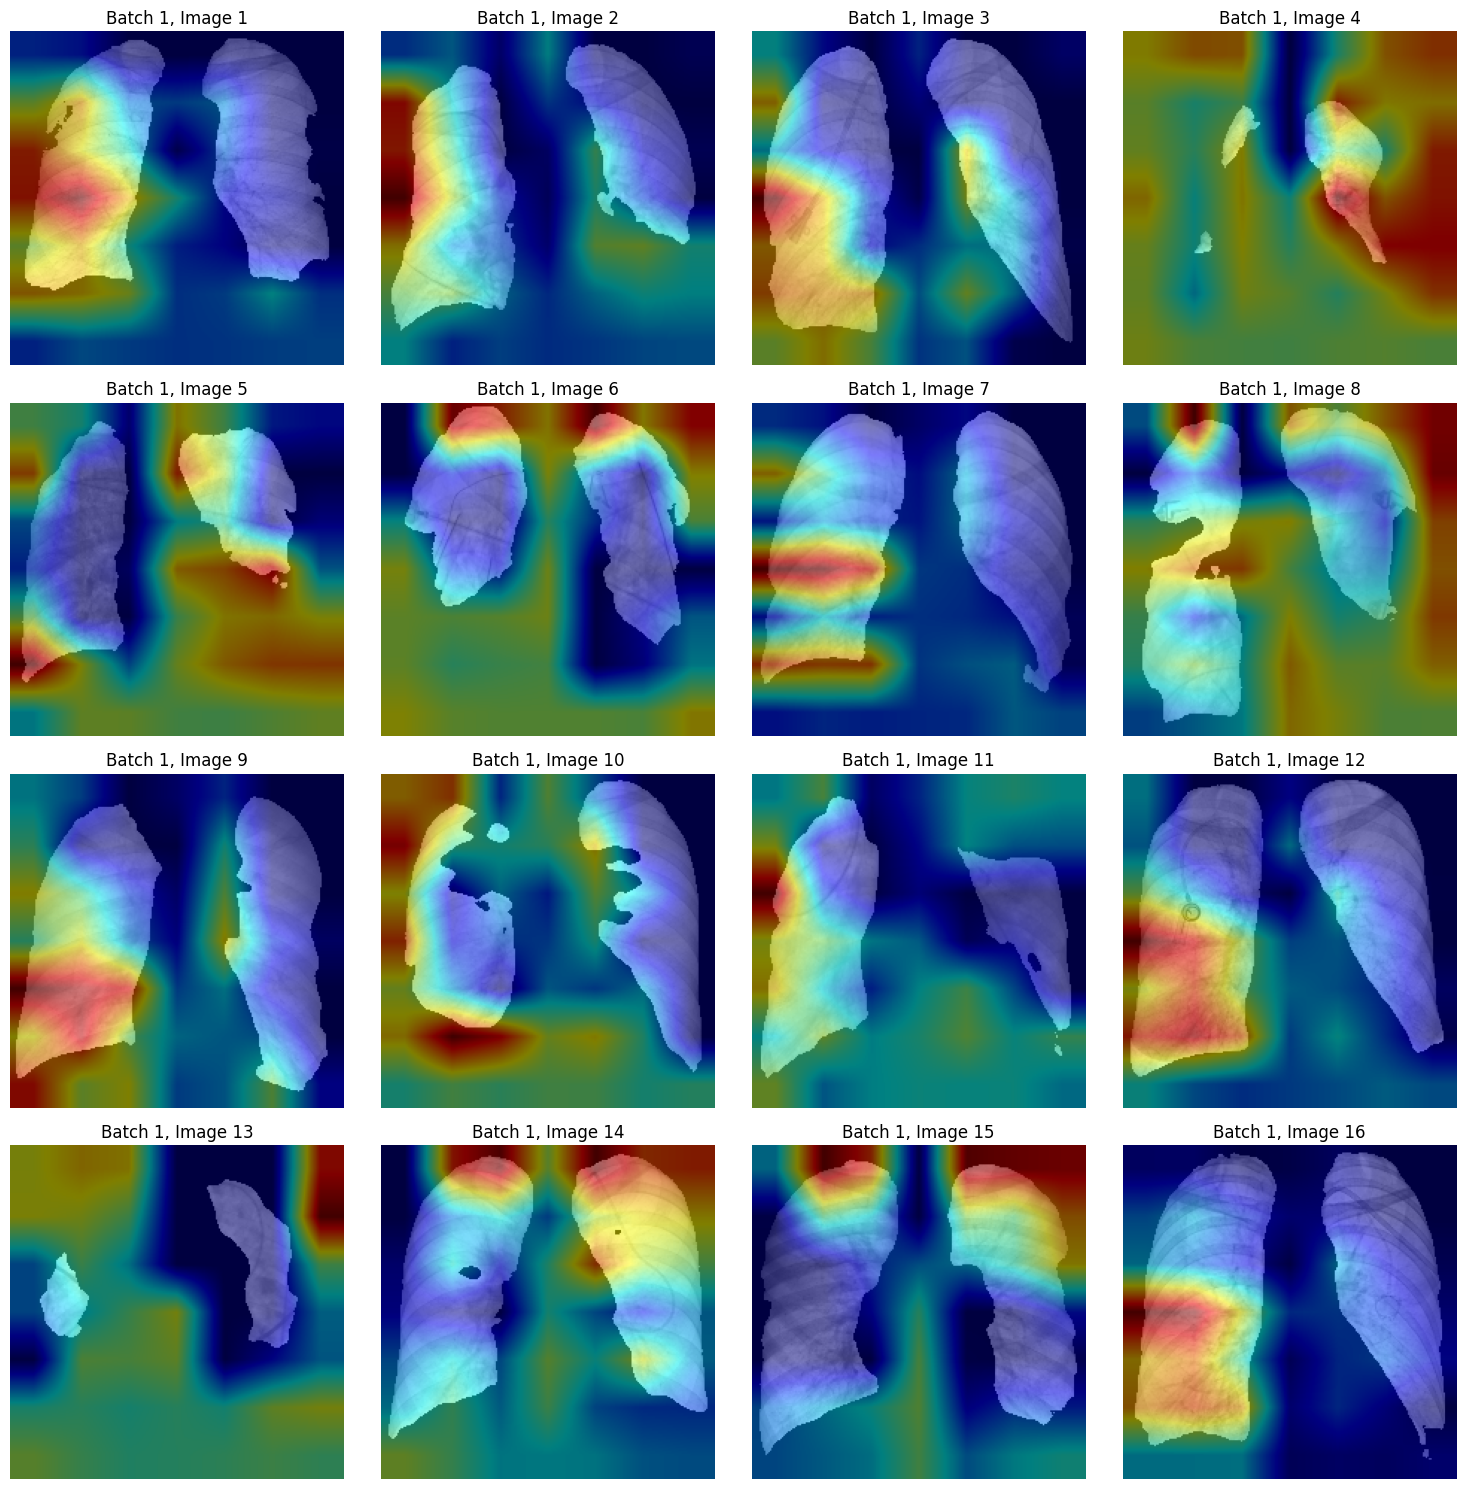

In [ ]:
visualize_cam_on_images(model, ROs_crop_dataloader, 16)

In [ ]:
df_ROs_crop_pre_paths = sorted(glob.glob('/content/ROIs_crop_pre/*.png'))
df_ROs_pre_crop = pd.DataFrame(columns=['image_path'], data=df_ROs_crop_pre_paths)
ROs_crop_pre_dataset = ROIDataset(df_ROs_pre_crop, transform=transform)
ROs_crop_pre_dataloader = DataLoader(ROs_crop_pre_dataset, batch_size=16, shuffle=False, num_workers=2)

Batch 1, Image 1
Batch 1, Image 2
Batch 1, Image 3
Batch 1, Image 4
Batch 1, Image 5
Batch 1, Image 6
Batch 1, Image 7
Batch 1, Image 8
Batch 1, Image 9
Batch 1, Image 10
Batch 1, Image 11
Batch 1, Image 12
Batch 1, Image 13
Batch 1, Image 14
Batch 1, Image 15
Batch 1, Image 16


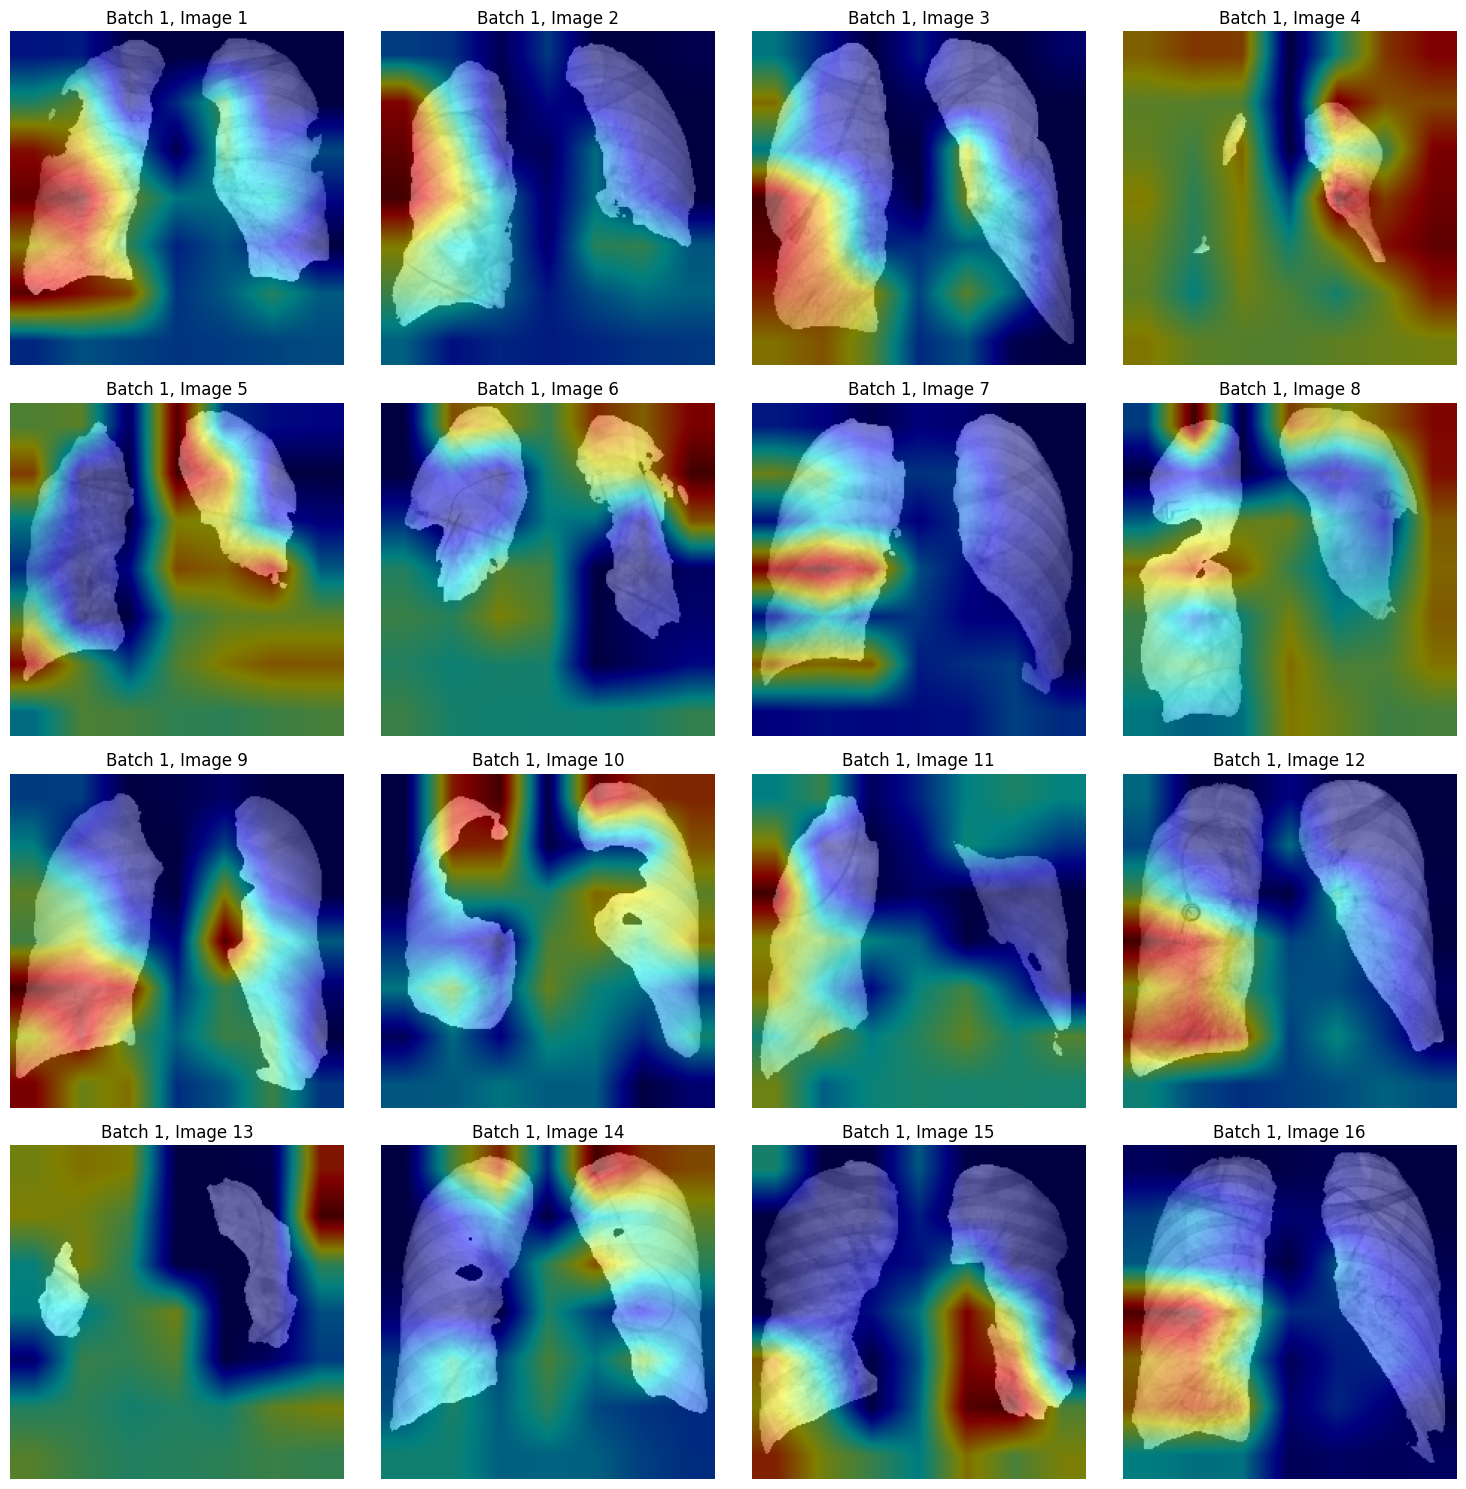

In [ ]:
visualize_cam_on_images(model, ROs_crop_pre_dataloader, 16)

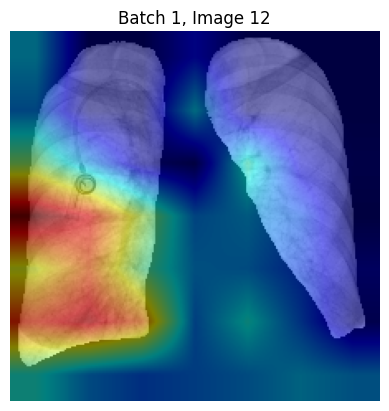

In [ ]:
visualize_cam_on_single_image(model, ROs_crop_pre_dataloader, 0, 11)